C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training data shape: (28792, 10, 8) (28792,)
Validation data shape: (5758, 10, 8) (5758,)
Testing data shape: (3840, 10, 8) (3840,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 20,925
Trainable params: 20,925
Non-traina

Epoch 29/40
900/900 [==============================] - 3s 3ms/step - loss: 0.0015 - mse: 0.0015 - MAE: 0.0325 - MAPE: 26324.6738 - accuracy: 0.0096 - val_loss: 0.0028 - val_mse: 0.0028 - val_MAE: 0.0442 - val_MAPE: 15303.4639 - val_accuracy: 3.4734e-04
Epoch 30/40
900/900 [==============================] - 3s 3ms/step - loss: 0.0015 - mse: 0.0015 - MAE: 0.0324 - MAPE: 26655.1367 - accuracy: 0.0096 - val_loss: 0.0028 - val_mse: 0.0028 - val_MAE: 0.0441 - val_MAPE: 15322.3477 - val_accuracy: 3.4734e-04
Epoch 31/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0015 - mse: 0.0015 - MAE: 0.0324 - MAPE: 26928.0430 - accuracy: 0.0096 - val_loss: 0.0028 - val_mse: 0.0028 - val_MAE: 0.0441 - val_MAPE: 15343.4180 - val_accuracy: 3.4734e-04
Epoch 32/40
900/900 [==============================] - 2s 3ms/step - loss: 0.0015 - mse: 0.0015 - MAE: 0.0324 - MAPE: 27182.7148 - accuracy: 0.0096 - val_loss: 0.0028 - val_mse: 0.0028 - val_MAE: 0.0441 - val_MAPE: 15366.8096 - val_accuracy:

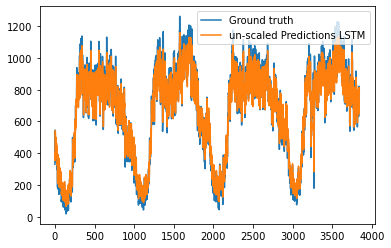

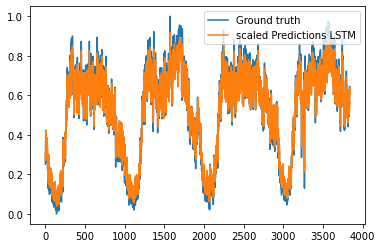

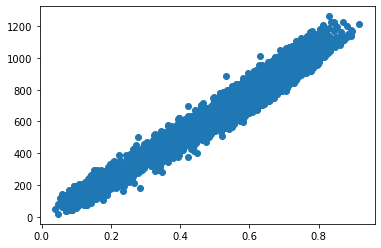

In [1]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
from pennylane import numpy as np
import pennylane as qml
import tensorflow as tf
###################################################################################################
###################################################################################################
Epochs=40
n_qubits = 4#Number of qubits should be the same as number of features, max number = 25
blocks = 1 #Νumber of blocks (AngleEmbedding and StronglyEntanglingLayers is one block )
layers = 1  #layers per block (multiple “layers” of StronglyEntanglingLayers per block )
copy="1" #Number to be set for title
model_name = "H1_R" + str(copy) +"_E" + str(Epochs) + "Q" + str(n_qubits) + "B" + str(blocks) + "L" + str(layers)
batch_size = 32
LR=0.0001 # Learning rate
splitsequence = 10 #more than 10 i.e. 20
patience= 100 #For early stopping
###################################################################################################
# Set the seed for weights initialization
seed = 42
tf.random.set_seed(seed)
###################################################################################################

dev = qml.device("default.qubit.tf", wires=n_qubits) #Run the model in classical CPU
# dev = qml.device("qiskit.aer", wires=n_qubits, shots=1000)

# Set the split ratios
train_ratio = 0.75  # 75% for training
val_ratio = 0.15  # 15% for validation
#Target
#Target
ms = 'MS701'
#%%
df = pd.read_csv('data_quantum.csv')

from lstm_timestamp import lstm_data
x0, y0 = lstm_data(ms,df,splitsequence)

#%%

# Calculate the lengths of each set
total_length = len(x0)
train_length = int(total_length * train_ratio)
val_length = int(total_length * val_ratio)
test_length = total_length - train_length - val_length
# Split the data
x_train = x0[:train_length]
y_train = y0[:train_length]
x_val = x0[train_length:train_length+val_length]
y_val = y0[train_length:train_length+val_length]
x_test = x0[train_length+val_length:]
y_test = y0[train_length+val_length:]
# Print the shapes of the datasets
print("Training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)
print("Testing data shape:", x_test.shape, y_test.shape)
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
from sklearn.preprocessing import MinMaxScaler
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
# Scale the training dataset
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
# Scale the validation dataset
x_val_scaled = scaler.fit_transform(x_val.reshape(-1, 1)).reshape(x_val.shape)
# Scale the test dataset
x_test_scaled = scaler.fit_transform(x_test.reshape(-1, 1)).reshape(x_test.shape)
y_train_scaled =  scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled =  scaler.fit_transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled =  scaler.fit_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################

# Define quantum node
# Added below to ensure the QNode is JIT compiled
@tf.function
@qml.qnode(dev, interface="tf", diff_method="backprop")
def qnode(inputs, weights):
    for i in range(blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits)) #STRONGLY ENTANGLING LAYERS
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weights_shape = (blocks, layers, n_qubits, 3) # Uncomment for Strongly entangling layers
tf.keras.backend.set_floatx("float32")
weight_shapes = {"weights": weights_shape}

####### Set seed for constant weights #######
inputs = tf.constant(np.random.random((batch_size, n_qubits))) #uncomment for random weights
#rng = tf.random.Generator.from_seed(seed)
#random_numbers = rng.uniform(shape=(batch_size, n_qubits))
#inputs = tf.constant(random_numbers)
######

##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
##########################-----------##########################
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
#%%
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

opt = keras.optimizers.Adam(learning_rate=LR) 

with tf.device('/device:GPU:0'):
    tf.keras.backend.set_floatx("float32")
    weight_shapes = {"weights": weights_shape}
    layer_1 = tf.keras.layers.LSTM(64,  activation='tanh', input_shape=(x0.shape[1],x0.shape[2]),dtype=tf.float32) ### input shape: timesteps, features
    layer_2 = tf.keras.layers.Dense(32, activation='tanh',  dtype=tf.float32)
    #layer_3 = tf.keras.layers.Dense(64, activation='linear', dtype=tf.float32)
    #layer_4 = tf.keras.layers.Dense(8, activation='linear', dtype=tf.float32)
    layer_P = tf.keras.layers.Dense(n_qubits, activation="tanh", dtype=tf.float32)
    #qlayer =  qml.qnn.KerasLayer(qnode, weight_shapes, n_qubits, dtype=tf.float32) 
    qlayer = tf.keras.layers.Dense(n_qubits, activation="tanh", dtype=tf.float32)
    layer_D = tf.keras.layers.Dense(1, activation="linear")
    model1 = tf.keras.models.Sequential([layer_1,layer_2,layer_P,qlayer,layer_D])
    
   # layer_4=keras.layers.TimeDistributed(Dense(4, activation='relu'))
    
    

#Compile model           
#model1.compile(loss='mse', optimizer=opt, metrics=['mean_absolute_error',"MAPE","MAE"])
model1.compile(loss='mse', optimizer=opt, metrics=['mse',"MAE","MAPE","accuracy"])
                              
# Define the EarlyStopping callback

early_stopping = EarlyStopping(monitor='val_loss',  mode='min',patience=patience, verbose=1)
# Define the Model checkpoint callback
#cp2 = ModelCheckpoint("model1/", monitor='val_loss',save_best_only=True)
#Fit model
print(model1.summary())
history = model1.fit(x_train_scaled, y_train_scaled, epochs=Epochs, batch_size=batch_size
                     ,validation_data=(x_val_scaled, y_val_scaled), callbacks=[time_callback,early_stopping],shuffle=False)
#%%

# Save the training history to a file
#history_file = model_name + "_history.txt"
#with open(history_file, 'w') as file:
#    file.write(str(history.history))

history_file = model_name + "_Summary.txt"
with open(history_file, 'w') as file:
    # Get the summary of the model architecture as a string
    summary_string = []
    model1.summary(print_fn=lambda x: summary_string.append(x))
# Process the summary string into a pandas DataFrame
    summary_data = [x.split() for x in summary_string[1:-1]]
    summary_df = pd.DataFrame(summary_data, columns=['Layer', 'Output','Shape', 'Param',"type","#"])
    summary_df["blocks"]=blocks
    summary_df["layers"]=layers
    summary_df["LR"]=LR
    summary_df["batch_size"]=batch_size
    summary_df["Epochs"]=Epochs
    summary_df["N_qubits"]=n_qubits
    summary_df["train_ratio"]=train_ratio
    summary_df["val_ratio"]=val_ratio
    summary_df["seed"]=seed
    summary_df["splitsequence"]=splitsequence
    summary_df["patience"]=patience
    summary_df["MS"]=ms
    file.write(str(summary_df[['Output','Param','blocks','layers',
                               'LR','batch_size','Epochs','N_qubits','train_ratio',
                               'val_ratio']].dropna()))
# make predictions Scaled and unscaled
pred_scaled = model1.predict(x_test_scaled)
pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(pred_scaled.shape)
print("------------------")
print("Test MSE:", mean_squared_error(y_test, pred_unscaled))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, pred_unscaled)))
print("Test MAE:", mean_absolute_error(y_test, pred_unscaled))
print("Test MAPE:", mean_absolute_percentage_error(y_test,pred_unscaled))
print("R2 Score:", r2_score(y_test, pred_unscaled, multioutput='variance_weighted'))
print("------------------")
print("Test MSE scaled:", mean_squared_error(y_test_scaled, pred_scaled))
print("Test RMSE scaled:", np.sqrt(mean_squared_error(y_test_scaled, pred_scaled)))
print("Test MAE scaled:", mean_absolute_error(y_test_scaled, pred_scaled))
print("Test MAPE scaled:", mean_absolute_percentage_error(y_test_scaled,pred_scaled))
print("R2 Score scaled:", r2_score(y_test_scaled, pred_scaled, multioutput='variance_weighted'))
print("------------------")
#%%
import matplotlib.pyplot as plt
plt.plot(y_test, label='Ground truth')
plt.plot(pred_unscaled, label='un-scaled Predictions LSTM')
plt.legend()
plt.show()

plt.plot(y_test_scaled, label='Ground truth')
plt.plot(pred_scaled, label='scaled Predictions LSTM')
plt.legend()
plt.show()

#%%
plt.scatter(pred_scaled, y_test)
plt.show()

# Save the training characteristics
#characteristics_file = model_name + "_characteristics.txt"
#with open(characteristics_file, 'w') as file:
#    file.write("Loss: {}\n".format(history.history['loss'][-1]))
    
#    file.write("Validation Loss: {}\n".format(history.history['val_loss'][-1]))

In [2]:
print("Time per epoch")
print(time_callback.times)

Time per epoch
[4.529378414154053, 2.6575961112976074, 2.310560703277588, 2.2820165157318115, 2.442594051361084, 2.555572748184204, 2.4975593090057373, 2.4695534706115723, 2.266507863998413, 2.4275426864624023, 2.3775322437286377, 2.2515041828155518, 2.306516647338867, 2.3975374698638916, 2.286512851715088, 2.2745094299316406, 2.3825342655181885, 2.2865118980407715, 2.1834897994995117, 2.2475032806396484, 2.3385233879089355, 2.435544967651367, 2.4930660724639893, 2.2685086727142334, 2.187490940093994, 2.261611223220825, 2.499917984008789, 2.605100393295288, 2.5450754165649414, 2.594581365585327, 2.4605519771575928, 2.4845569133758545, 2.4815564155578613, 2.519564390182495, 2.7476155757904053, 2.426543951034546, 2.670598030090332, 2.436546564102173, 2.4625513553619385, 2.5755770206451416]


# Training Characteristics

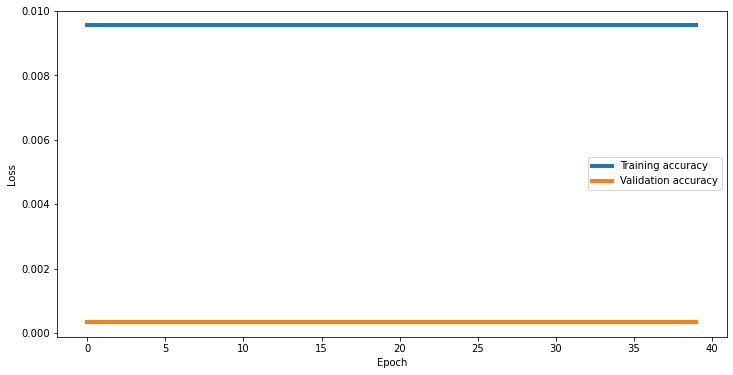

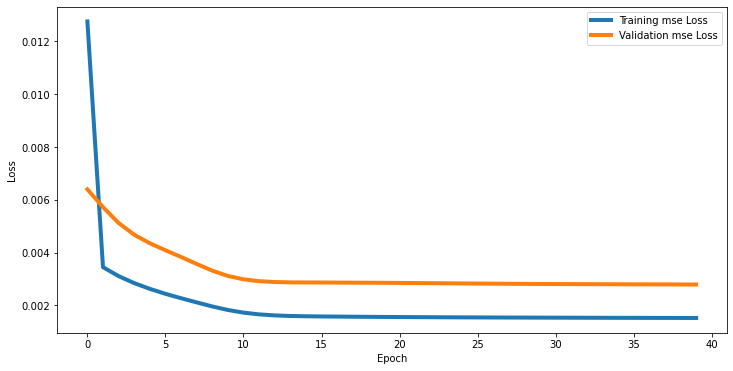

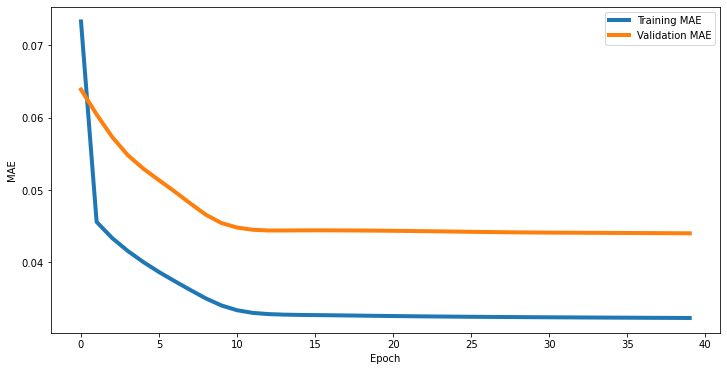

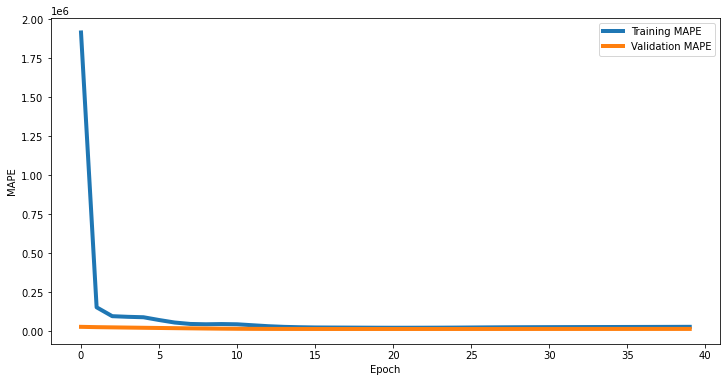

In [3]:
# Plot training characteristics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training accuracy',linewidth=4)
plt.plot(history.history['val_accuracy'], label='Validation accuracy',linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training mse Loss',linewidth=4)
plt.plot(history.history['val_loss'], label='Validation mse Loss',linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['MAE'], label='Training MAE',linewidth=4)
plt.plot(history.history['val_MAE'], label='Validation MAE',linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['MAPE'], label='Training MAPE',linewidth=4)
plt.plot(history.history['val_MAPE'], label='Validation MAPE',linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('MAPE')
#plt.ylim(0, 200)  # Set the y-axis limits
plt.legend()
plt.show()

# Predictions

### Predictions scaled

Test MSE: 0.05009182346111079
Test RMSE: 0.002509190777659089
Test MAE: 0.041374491260225826
Test MAPE: 55876710127.05604
R2 Score: 0.9531698826756931


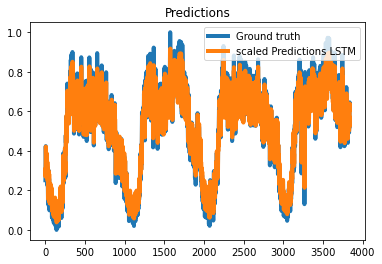

In [4]:
print("Test MSE:", mean_squared_error(y_test_scaled, pred_scaled,squared=False))
print("Test RMSE:", mean_squared_error(y_test_scaled, pred_scaled,squared=True))
print("Test MAE:", mean_absolute_error(y_test_scaled, pred_scaled))
print("Test MAPE:", mean_absolute_percentage_error(y_test_scaled,pred_scaled))
print("R2 Score:", r2_score(y_test_scaled, pred_scaled, multioutput='variance_weighted'))
#%%
import matplotlib.pyplot as plt
plt.title("Predictions")
plt.plot(y_test_scaled, label='Ground truth',linewidth=4)
plt.plot(pred_scaled, label='scaled Predictions LSTM',linewidth=4)
plt.legend()
plt.show()

### Predictions without scaling

Test MSE: 62.32771896004757
Test RMSE: 3884.744550762673
Test MAE: 51.481011298941546
Test MAPE: 11.109344979829165
R2 Score: 0.9531698898344583


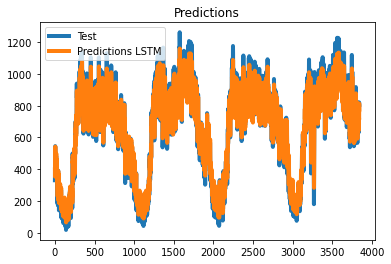

In [5]:
print("Test MSE:", mean_squared_error(y_test, pred_unscaled,squared=False))
print("Test RMSE:", mean_squared_error(y_test, pred_unscaled,squared=True))
print("Test MAE:", mean_absolute_error(y_test, pred_unscaled))
print("Test MAPE:", mean_absolute_percentage_error(y_test,pred_unscaled)*100)
print("R2 Score:", r2_score(y_test, pred_unscaled, multioutput='variance_weighted'))
#%%
import matplotlib.pyplot as plt
plt.title("Predictions")
plt.plot(y_test, label='Test ',linewidth=4)
plt.plot(pred_unscaled, label='Predictions LSTM',linewidth=4)
plt.legend()
plt.show()

# Predictions plots

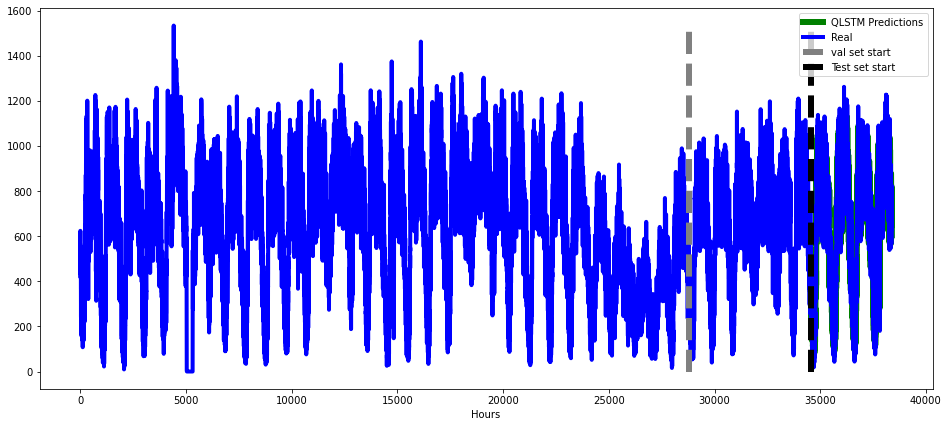

In [6]:
plt.figure(figsize=(16, 7))
#plt.plot(np.concatenate((y_train,y_val, y_test)), label='Test ')
nanarray = np.full(len(y_train)+len(y_val), np.nan)
plt.plot(np.array(np.concatenate((nanarray, np.array(pred_unscaled).flatten()))), label='QLSTM Predictions', linewidth=6, color="green")
plt.plot(np.concatenate((y_train,y_val,y_test)), label='Real', linewidth=4, color="blue")
plt.ylabel('')
plt.xlabel('Hours')
plt.vlines(len(np.array(y_train)), ymin = min(y_train), ymax = max(y_train), label = "val set start", linestyles = "dashed", linewidth=6, color="grey")
plt.legend()
plt.vlines(len(np.array(np.concatenate((y_train,y_val)))), ymin = min(y_train), ymax = max(y_train), label = "Test set start", linestyles = "dashed", linewidth=6, color="black")
plt.legend()
plt.show()

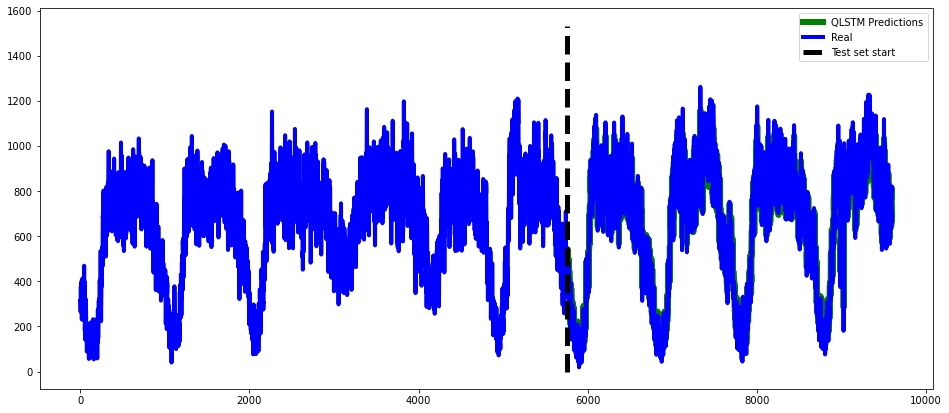

In [7]:
plt.figure(figsize=(16, 7))
#plt.plot(np.concatenate((y_train,y_val, y_test)), label='Test ')
nanarray = np.full(len(y_val), np.nan)
plt.plot(np.array(np.concatenate((nanarray, np.array(pred_unscaled).flatten()))), label='QLSTM Predictions'
         , linewidth=6, color="green")
plt.plot(np.concatenate((y_val,y_test)), label='Real', linewidth=4, color="blue")
plt.ylabel('')
plt.xlabel('')
plt.vlines(len((y_val)), min(y_train), ymax = max(y_train), label = "Test set start", linestyles = "dashed", linewidth=5, color="black")
plt.legend()
plt.show()

In [8]:
# Save plots to a file
# Create a DataFrame from the arrays
import pandas as pd
df1 = pd.DataFrame()
file_name = model_name + "_predictions.csv"
arr1=np.concatenate((y_train,y_val,y_test))
arr2=np.concatenate((y_train_scaled,y_val_scaled, np.array(pred_scaled).flatten()))
arr3=np.concatenate((y_train,y_val, np.array(pred_unscaled).flatten()))
#df = pd.DataFrame({'Real': arr1,  'QLSTM': arr2})
# Add the array to the specified column
df1["Q" + str(n_qubits) + "B" + str(blocks) + "L" + str(layers)]=np.nan
df1["Real"] = arr1
df1["Pred s"] = arr2
df1["Pred"] = arr3
df1["----"]=np.nan
df1["test MSE s"]=mean_squared_error(y_test_scaled, pred_scaled, squared=False)
df1["test RMSE s"]=mean_squared_error(y_test_scaled, pred_scaled, squared=True)
df1["test MAE s"]=mean_absolute_error(y_test_scaled, pred_scaled )
df1["test MAPE s"]=mean_squared_error(y_test_scaled, pred_scaled)
df1["R2 s"]=r2_score(y_test_scaled, pred_scaled, multioutput='variance_weighted')
df1["--~--"]=np.nan
df1["test MSE"]=mean_squared_error(y_test, pred_unscaled, squared=False)
df1["test RMSE"]=mean_squared_error(y_test, pred_unscaled, squared=True)
df1["test MAE"]=mean_absolute_error(y_test, pred_unscaled)
df1["test MAPE"]=mean_absolute_percentage_error(y_test, pred_unscaled)
df1["R2 "]=r2_score(y_test, pred_unscaled, multioutput='variance_weighted')
# Save the DataFrame as a CSV file
df1.to_csv(file_name, index=False)
print("Arrays saved as", file_name)

Arrays saved as H1_R1_E40Q4B1L1_predictions.csv


In [9]:
file_name = model_name + "_history.csv"
df2 = pd.DataFrame()
df2["Q" + str(n_qubits) + "B" + str(blocks) + "L" + str(layers)]=np.nan
df2["loss"]=history.history["loss"]
df2["val_loss"]=history.history["val_loss"]
df2["MAE"]=history.history["MAE"]
df2["val_MAE"]=history.history["val_MAE"]
df2["MAPE"]=history.history["MAPE"]
df2["val_MAPE"]=history.history["val_MAPE"]
df2.to_csv(file_name, index=False)

In [10]:
#len y_train + y_val
len(np.array(np.concatenate((y_train,y_val))))

34550